In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F # activation function ReLU
from torch.optim import SGD # stochastic gradient descent

import lightning as L
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

# Parameters

In [3]:
input_doses = torch.linspace(start=0, end=1, steps=11)

inputs = torch.tensor([0.,0.5,1.])
labels = torch.tensor([0.,1.,0.])
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

# Lightning NN

In [4]:
class BasicLightning(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7),requires_grad=False) # don't optims it
        self.b00 = nn.Parameter(torch.tensor(-0.85),requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8),requires_grad=False)
        self.w10 = nn.Parameter(torch.tensor(12.6),requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.),requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7),requires_grad=False)
        self.final_bias = nn.Parameter(torch.tensor(-16.),requires_grad=False)


    def forward(self, input):
        input_to_top_relu = input*self.w00+self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scale_top_relu_output = top_relu_output*self.w01
        
        input_to_bottom_relu = input*self.w10+self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scale_bottom_relu_output = bottom_relu_output*self.w11
        
        input_to_final_relu = scale_top_relu_output+scale_bottom_relu_output+self.final_bias
        output = F.relu(input_to_final_relu)
        return output

Text(0.5, 0, 'Dose')

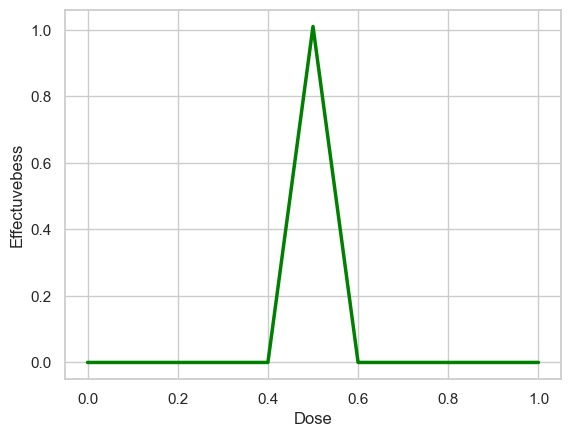

In [5]:
model = BasicLightning()
output_values = model(input_doses)
sns.set_theme(style="whitegrid")
sns.lineplot(x=input_doses, y=output_values, color='green',linewidth=2.5)
plt.ylabel('Effectuvebess')
plt.xlabel('Dose')

# Lightning NN with training

In [ ]:
class BasicLightningTrain(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7),requires_grad=False) # don't optims it
        self.b00 = nn.Parameter(torch.tensor(-0.85),requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8),requires_grad=False)
        self.w10 = nn.Parameter(torch.tensor(12.6),requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.),requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7),requires_grad=False)
        self.final_bias = nn.Parameter(torch.tensor(0.),requires_grad=True)
        
        self.learning_rate = 0.01


    def forward(self, input):
        input_to_top_relu = input*self.w00+self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scale_top_relu_output = top_relu_output*self.w01
        
        input_to_bottom_relu = input*self.w10+self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scale_bottom_relu_output = bottom_relu_output*self.w11
        
        input_to_final_relu = scale_top_relu_output+scale_bottom_relu_output+self.final_bias
        output = F.relu(input_to_final_relu)
        return output

Text(0.5, 0, 'Dose')

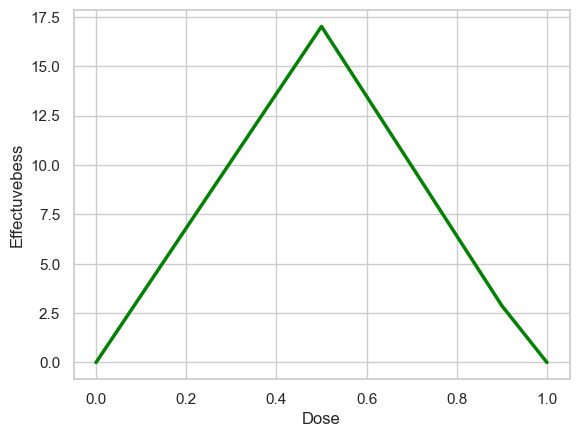

In [21]:
model = BasicLightningTrain()
output_values = model(input_doses)
sns.set_theme(style="whitegrid")
sns.lineplot(x=input_doses, y=output_values.detach(), color='green',linewidth=2.5)
plt.ylabel('Effectuvebess')
plt.xlabel('Dose')

In [22]:
class BasicLightningTrain_Opt(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7),requires_grad=False) # don't optims it
        self.b00 = nn.Parameter(torch.tensor(-0.85),requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8),requires_grad=False)
        self.w10 = nn.Parameter(torch.tensor(12.6),requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.),requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7),requires_grad=False)
        self.final_bias = nn.Parameter(torch.tensor(0.),requires_grad=True)
        
        self.learning_rate = 0.01


    def forward(self, input):
        input_to_top_relu = input*self.w00+self.b00
        top_relu_output = F.relu(input_to_top_relu)
        scale_top_relu_output = top_relu_output*self.w01
        
        input_to_bottom_relu = input*self.w10+self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scale_bottom_relu_output = bottom_relu_output*self.w11
        
        input_to_final_relu = scale_top_relu_output+scale_bottom_relu_output+self.final_bias
        output = F.relu(input_to_final_relu)
        return output
        
    def configure_optimizers(self):
        return(SGD(self.parameters(), lr=self.learning_rate))
    
    def training_step(self, batch, batch_idx):
        input_i, label_i = batch
        output_i = self.forward(input_i)
        loss = (output_i-label_i)**2
        return loss    

In [25]:
model = BasicLightningTrain_Opt()
trainer = L.Trainer(max_epochs=2000)

tuner = L.pytorch.tuner.Tuner(trainer)
lr_find_results = tuner.lr_find(model, 
                                       train_dataloaders = dataloader,
                                       min_lr = 0.001,
                                       max_lr = 1.,
                                       early_stop_threshold = None)
new_lr = lr_find_results.suggestion()
print(f"lr_find suggests {new_lr:.5f} for the learning rate.")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 874.27it/s]
Learning rate set to 0.002137962089502232
Restoring states from the checkpoint path at /Users/yifanli/Github/Machine_Learning/code/transformer/.lr_find_bfb114a5-072b-4f99-b110-4e0c19401faf.ckpt
Restored all states from the checkpoint at /Users/yifanli/Github/Machine_Learning/code/transformer/.lr_find_bfb114a5-072b-4f99-b110-4e0c19401faf.ckpt


lr_find suggests 0.00214 for the learning rate.


In [26]:
model.learning_rate = new_lr
trainer.fit(model, train_dataloaders = dataloader)
print(model.final_bias.data)


  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 3/3 [00:00<00:00, 604.60it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 3/3 [00:00<00:00, 410.90it/s, v_num=4]
tensor(-16.0070)


Text(0.5, 0, 'Dose')

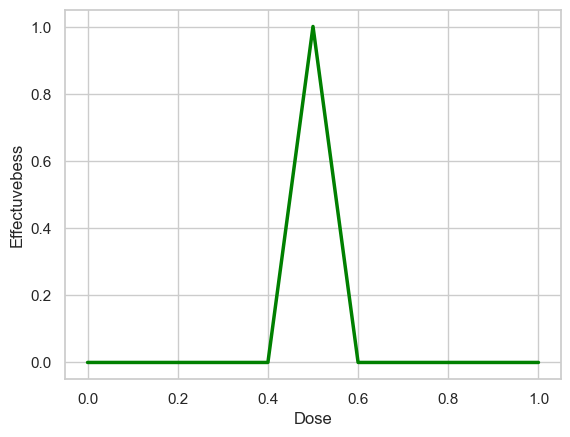

In [27]:
output_values = model(input_doses)
sns.set_theme(style="whitegrid")
sns.lineplot(x=input_doses, y=output_values.detach(), color='green',linewidth=2.5)
plt.ylabel('Effectuvebess')
plt.xlabel('Dose')

# GPU speed up

In [ ]:
model = BasicLightningTrain_Opt()

### difference
trainer = L.Trainer(max_epochs=2000,accelerator='auto', devices='auto')

tuner = L.pytorch.tuner.Tuner(trainer)
lr_find_results = tuner.lr_find(model, 
                                       train_dataloaders = dataloader,
                                       min_lr = 0.001,
                                       max_lr = 1.,
                                       early_stop_threshold = None)
new_lr = lr_find_results.suggestion()
print(f"lr_find suggests {new_lr:.5f} for the learning rate.")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/machine_learning/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/machine_learning/lib/python3.13/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 799.73it/s]
Learning rate set to 0.002137962089502232
Restoring states from the checkpoint path at /Users/yifanli/Github/Machine_Learning/code/transformer/.lr_find_e502e5a0-08ba-4a79-8d7e-1216bab

lr_find suggests 0.00214 for the learning rate.


In [29]:
model.learning_rate = new_lr
trainer.fit(model, train_dataloaders = dataloader)
print(model.final_bias.data)


  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 3/3 [00:00<00:00, 718.04it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 3/3 [00:00<00:00, 473.72it/s, v_num=5]
tensor(-16.0070)


Text(0.5, 0, 'Dose')

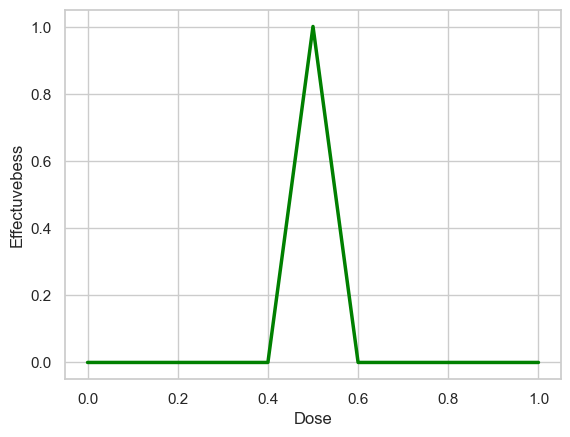

In [30]:
output_values = model(input_doses)
sns.set_theme(style="whitegrid")
sns.lineplot(x=input_doses, y=output_values.detach(), color='green',linewidth=2.5)
plt.ylabel('Effectuvebess')
plt.xlabel('Dose')